In [70]:
# 01 - Params

url_base = "https://www.twingalaxies.com/showthread.php/176004-Dispute-Jeremy-Young-Arcade-Donkey-Kong-Points-Hammer-Allowed-Player-Billy-L-Mitchell-Score-1-062-800/page"
file_name = "./twingalaxies_dispute_billymitchell.xls"
file_name_linklist = "./twingalaxies_dispute_billymitchell_linklist.csv"

# 02 - Definitions and imports

import urllib
import pandas as pd
import numpy as np
import bs4
import time
import re
import dateutil
import collections
import datetime
import networkx as nx
import operator
import matplotlib.pyplot as plt


def get_post_id(post_parent):
        #print(post_parent)
        try:
            post_counter = post_parent.find("a", {"class": "postcounter"})
            return post_counter.contents[0]
        except AttributeError:
            return None


def read_thread_df(file_name):
    try:
        all_loaded_df = pd.read_excel(file_name)
    except FileNotFoundError:
        return None
        
    for col_name in all_loaded_df.columns:
        if "_list" in col_name:
            all_loaded_df.loc[:, col_name] = all_loaded_df.loc[:, col_name].apply(lambda x: x.split(", ") if not pd.isnull(x) else [])

    return all_loaded_df


def write_thread_df(all_df, file_name):

    all_listasstrings_df = all_df.copy()

    for col_name in all_listasstrings_df.columns:
        if "_list" in col_name:
            all_listasstrings_df.loc[:, col_name] = all_listasstrings_df.loc[:, col_name].apply(lambda x: re.sub("\[|\]|\'", "", str(x)))

    all_listasstrings_df.to_excel(file_name, index=None)
    all_listasstrings_df.to_csv(file_name.replace("xls", "csv"), sep=";", quoting=2, encoding="utf-8", index=None)



def get_edgelist(all_df, col_name_list):
    df = all_df.copy().rename({"user_name": "to", col_name_list: "from"}, axis="columns").set_index(["to", "post_id"])
    likes_edgelist = (pd.melt(df["from"].apply(pd.Series).reset_index(), 
                                 id_vars=["to", "post_id"],
                                 value_name="from")
                         .set_index(["to", "post_id"])
                         .drop("variable", axis=1)
                         .dropna()
                         .sort_index()
                         )

    edgelist_noedgename = likes_edgelist.reset_index().groupby(["from", "to"]).count().rename({"post_id": "weight"}, axis= "columns").reset_index()
    edgelist_noedgename_indexed = edgelist_noedgename.set_index(["from", "to"])
    return edgelist_noedgename_indexed


def calc_poster_weight(thanks_likes_edgelist_noindex, weight_var):
    # Calculate graphe from edge list
    G = nx.from_pandas_dataframe(thanks_likes_edgelist_noindex, "from", "to", weight_var, create_using=nx.DiGraph())

    # Use centrality as proxy for poster weight = importance (by likes and thanks)
    centrality_nodes = nx.eigenvector_centrality(G, weight=weight_var)
    poster_weight_dict = collections.OrderedDict(sorted(centrality_nodes.items(), key=operator.itemgetter(1), reverse=True))
    poster_weight_series = pd.Series(poster_weight_dict)

    # Calculate poster weigths
    poster_weight_df = pd.DataFrame(poster_weight_series/(poster_weight_series.sum()), columns=["poster_weight_rel"])
    return poster_weight_df

In [71]:
## 3 - Calculate poster and post scores based on network centrality
## https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.algorithms.centrality.eigenvector_centrality.html

all_df = read_thread_df(file_name)

thanks_edgelist = get_edgelist(all_df, "thanks_list")
likes_edgelist = get_edgelist(all_df, "likes_list")

thanks_likes_edgelist = thanks_edgelist.join(likes_edgelist, how="outer", lsuffix="_thanks", rsuffix="_likes").fillna(0)
weight_sums = thanks_likes_edgelist.sum()
thanks_factor = weight_sums["weight_likes"]/weight_sums["weight_thanks"]

thanks_likes_edgelist["weight_total"] = thanks_factor*thanks_likes_edgelist["weight_thanks"] + thanks_likes_edgelist["weight_likes"]
thanks_likes_edgelist_noindex = thanks_likes_edgelist.reset_index()

poster_weight_df = calc_poster_weight(thanks_likes_edgelist_noindex, "weight_total")
    
poster_weight_df["poster_weight_abs"] = poster_weight_df["poster_weight_rel"]*weight_sums["weight_likes"]*2 + 1
poster_weight_df.index.names = ['user_name']

# Calculate how many likes/thanks were given by a particular person
thanks_likes_from = thanks_likes_edgelist.groupby("from").sum()#.set_index("from")
thanks_likes_from.index.names = ['user_name']
poster_weight_likes_thanks = poster_weight_df.join(thanks_likes_from, how="outer")
poster_weight_likes_thanks["likes_weight"] = (poster_weight_likes_thanks["poster_weight_abs"]/poster_weight_likes_thanks["weight_total"]).fillna(0)
poster_weight_likes_thanks["thanks_weight"] = poster_weight_likes_thanks["likes_weight"] * thanks_factor

# Finally, add post score and rank to the global df
all_df["post_score"] = (all_df["likes_list"].apply(lambda x: sum([poster_weight_likes_thanks.loc[y, "likes_weight"] for y in x]))
            + all_df["thanks_list"].apply(lambda x: sum([poster_weight_likes_thanks.loc[y, "thanks_weight"] for y in x])))

all_df["post_rank"] = all_df["post_score"].rank(ascending=False)

write_thread_df(all_df, file_name)
all_df.reset_index().sort_values("post_rank").head(5)

,index,post_id,post_time,url_post,user_name,post_score,post_rank,content,links_list,links_number,cites_list,cites_number,thanks_list,thanks_number,likes_list,likes_number
1425,1425,#1426,2018-02-22 13:09:00,https://www.twingalaxies.com/showthread.php/17...,Jace Hall,196.579948,1.0,For those that may have missed our previous up...,[http://pro.jvc.com/prof/attributes/tech_desc....,3,[],0,"[Fendersonia, xelnia, JJT_Defender, Welp, TWIN...",10,"[homerwannabee, Fendersonia, sion fiction, Rob...",16
1568,1568,#1569,2018-02-28 03:13:00,https://www.twingalaxies.com/showthread.php/17...,J.C. Harrist,177.533064,2.0,This is the result of extensive testing shot a...,"[https://i.imgur.com/8urVyFn.jpg, https://i.im...",7,[],0,"[HugDD, Jace Hall, Snazzavich, xelnia, portman...",17,"[HugDD, Snazzavich, xelnia, portmanteau, grapp...",20
1096,1096,#1097,2018-02-13 20:34:00,https://www.twingalaxies.com/showthread.php/17...,Snowflake,150.807583,3.0,"well, although I knew walking in I was probabl...",[],0,[],0,[sprinter461],1,"[The Evener, thegamer1185, dwayne richard, kev...",5
1964,1964,#1965,2018-03-19 18:46:00,https://www.twingalaxies.com/showthread.php/17...,The Evener,139.691899,4.0,##### START OF QUOTE ##### \n Originally Poste...,[],0,"[xelnia, xelnia]",2,[],0,"[q43, Robert.F, YesAffinity]",3
2934,2934,#2935,2018-04-09 19:05:00,https://www.twingalaxies.com/showthread.php/17...,maximumsteve,124.275805,5.0,Greetings All. So I am relaying the summary an...,[],0,[],0,"[Leoric, CWK, sprinter461, Rev John, ant3x7, s...",20,"[Leoric, CWK, HectorTelloc, timhett, sprinter4...",20


<h3>Stats

In [72]:
## General poster statistics

participants_active = set(all_df["user_name"])
participants_passive = (set(thanks_edgelist.reset_index()["from"]) | set(likes_edgelist.reset_index()["from"])) - participants_active
print("Active posters: " + str(len(participants_active)))
print("Only likers/thankers: " + str(len(participants_passive)))

Active posters: 151
Only likers/thankers: 145


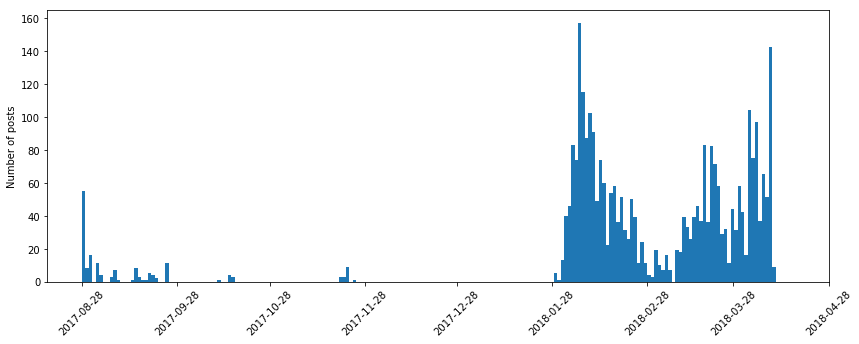

In [73]:
## Thread timeline

post_time_df = pd.DataFrame(all_df["post_time"].copy())
post_time_df["unix"] = post_time_df.astype(np.int64)/1000000000
post_time_df = post_time_df.set_index("post_time")

epoch = datetime.datetime.utcfromtimestamp(0)
ticks = [{"value": post_time_df.min()}]
ticks[0]["date"] = datetime.datetime.fromtimestamp(ticks[0]["value"])

while (ticks[-1]["value"] < post_time_df.max()).bool():
    ticks += [{"date": ticks[-1]["date"] + dateutil.relativedelta.relativedelta(months=1)}]
    ticks[-1]["value"] = (ticks[-1]["date"] - epoch).total_seconds()

ax = post_time_df.plot(kind='hist', figsize=[14,5], bins=200, rot=45, legend=False, xticks=[float(x["value"]) for x in ticks])
labels_new = [x["date"].strftime('%Y-%m-%d') for x in ticks]
ax.set_xticklabels(labels_new)
ax.set_ylabel("Number of posts")

plt.show()

In [79]:
## MVP : Most valuable posters - absolute and relative to number of posts

file_name_userimportance_total = "./twingalaxies_dispute_billymitchell_userimportance_total.csv"
file_name_userimportance_perpost = "./twingalaxies_dispute_billymitchell_userimportance_bypost.csv"

# Absolute
poster_weight_df.reset_index().drop("poster_weight_abs", axis="columns").rename({"poster_weight_rel": "poster_weight_abs"}, axis="columns").to_csv(file_name_userimportance_total, sep=";", quoting=2, encoding="utf-8", index=None)

# Relative to number of posts
post_number_df = all_df.groupby("user_name").agg({"post_id": "count"}).reset_index().rename({"user_name": "to", "post_id": "post_number"}, axis="columns")

thanks_likes_edgelist_noindex_posts = thanks_likes_edgelist_noindex.merge(post_number_df, on=["to"], how="left")
thanks_likes_edgelist_noindex_posts["weight_total_per_post"] = thanks_likes_edgelist_noindex_posts["weight_total"] / thanks_likes_edgelist_noindex_posts["post_number"]

poster_weight_per_post_df = calc_poster_weight(thanks_likes_edgelist_noindex_posts, "weight_total_per_post")
poster_weight_per_post_df.reset_index().rename({"poster_weight_rel": "poster_weight_per_post"}, axis="columns").to_csv(file_name_userimportance_perpost, sep=";", quoting=2, encoding="utf-8", index=None)

poster_weight_df.drop("poster_weight_abs", axis="columns").head(10)

,poster_weight_rel
user_name,
Jace Hall,0.139138
FBX,0.070638
RTM,0.052633
YesAffinity,0.048522
The Evener,0.046177
WCopeland,0.040417
Snowflake,0.030281
bh_,0.028956
xelnia,0.021195


In [80]:
## Most valuable links

all_df = read_thread_df("/home/andarin/Programming/twingalaxies_dispute_billymitchell.xls")
link_df = (pd.DataFrame(
            [(link, array[1]) for array in all_df[["links_list", "post_score"]].values for link in array[0]])
             .rename({0: "link", 1: "score"}, axis="columns")
             .groupby("link").agg({"score": sum})
             .reset_index()
             .sort_values("score", ascending=False)
            )

link_df.to_csv(file_name_linklist, sep=";", quoting=2, encoding="utf-8", index=None)

print("Number of links: " + str(link_df.shape[0]))

link_df.head(10)

Number of links: 1119


,link,score
39,http://pro.jvc.com/prof/attributes/tech_desc.j...,197.199081
619,https://www.twingalaxies.com/attachment.php?s=...,196.579948
618,https://www.twingalaxies.com/attachment.php?s=...,196.579948
235,https://i.imgur.com/YLzTtcJ.jpg,177.533064
188,https://i.imgur.com/8urVyFn.jpg,177.533064
196,https://i.imgur.com/DGcptiw.jpg,177.533064
179,https://i.imgur.com/4ggiJbt.jpg,177.533064
293,https://i.imgur.com/vgJ3gJM.jpg,177.533064
254,https://i.imgur.com/eczstjG.jpg,177.533064
290,https://i.imgur.com/uoJBQl5.jpg,177.533064
